In [1]:
%matplotlib inline
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import d2l_tools as d2l

生成数据集
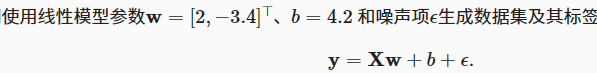

In [2]:
# 生成具有噪声的数据集 
def synthetic_data(w,b,num_examples):
    x = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(x,w) + b
    # 增加噪声
    y += torch.normal(0,0.01,y.shape)
    return x, y.reshape((-1,1))

In [3]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
# 生成1000个样本
features, labels = synthetic_data(true_w,true_b,1000)

In [4]:
print('features:',features[0],'\nlabel',labels[0])

features: tensor([ 0.8212, -0.3986]) 
label tensor([7.1973])


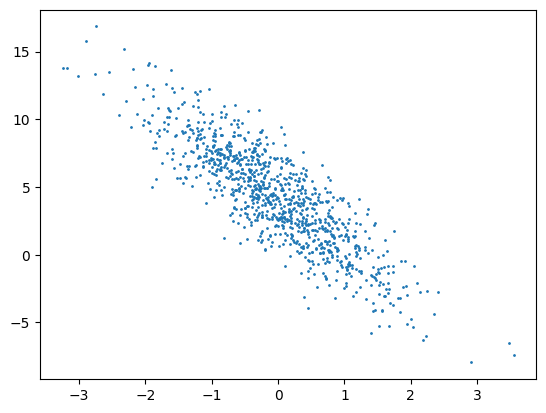

In [5]:
# 可视化第二个特征features[:, 1]和labels的散点图
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

小批量读取数据集

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 生成索引
    indices = list(range(num_examples))
    # 打乱索引 (随机选择)
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

In [7]:
# 展示小批量运算
batch_size = 10
for x, y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    break
"""
注意：此迭代方式执行效率极低，应尽量使用内置迭代器实现 
"""

tensor([[-1.1440,  0.1876],
        [-0.1171,  1.2382],
        [ 0.2217, -1.2861],
        [ 0.2883,  1.0535],
        [-0.6333, -2.6341],
        [ 1.5120,  0.3414],
        [-0.4468,  0.0716],
        [-1.0208,  1.6801],
        [ 0.6784, -0.7639],
        [-0.6287,  1.1796]]) 
 tensor([[ 1.2674],
        [-0.2516],
        [ 9.0051],
        [ 1.1942],
        [11.8749],
        [ 6.0556],
        [ 3.0529],
        [-3.5428],
        [ 8.1417],
        [-1.0533]])


'\n注意：此迭代方式执行效率极低，应尽量使用内置迭代器实现 \n'

初始化模型参数

In [8]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

定义模型

In [9]:
def linreg(x,w,b):
    # 线性回归模型
    return torch.matmul(x,w)+b

定义损失函数

In [10]:
def squared_loss(y_hat,y):
    # 均方误差
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 本地修改，无需return
            param.grad.zero_()

训练
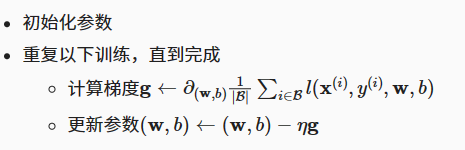

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

times = d2l.Timer()

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)
        l.sum().backward()
        # 更新参数 w，b
        sgd([w,b], lr, batch_size)
    # 计算每一轮的loss
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):.5f}')
times.stop()

epoch 1, loss 0.04067
epoch 2, loss 0.00017
epoch 3, loss 0.00005


0.8067243099212646

In [13]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([ 0.0008, -0.0002], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0005], grad_fn=<RsubBackward1>)


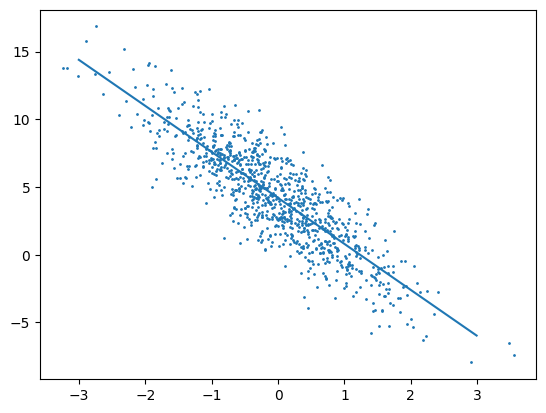

In [14]:
# 可视化回归成果 features[:,1]上可视化
x = torch.arange(-3,3,0.01)
y = x * w[1] + b

plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
# 画出回归曲线
plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

***练习***
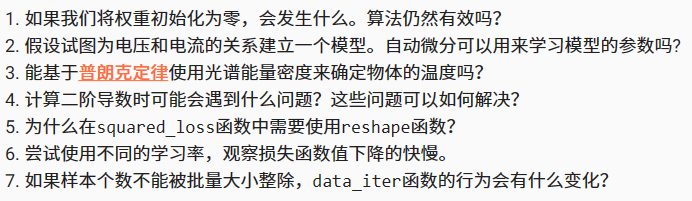

In [15]:
# QA1 仍然有效，与w,b初始值无关
"""
w = torch.tensor([0,0],dtype=torch.float32,requires_grad=True).reshape(2,1)
b = torch.tensor([0],dtype=torch.float32,requires_grad=True)

报错: unsupported operand type(s) for *: 'float' and 'NoneType'.
"""
w = torch.zeros(2,1,requires_grad=True)
b = torch.zeros(1,requires_grad=True)

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)
        l.sum().backward()
        # 更新参数 w，b
        sgd([w,b], lr, batch_size)
    # 计算每一轮的loss
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):.5f}')

epoch 1, loss 0.04055
epoch 2, loss 0.00016
epoch 3, loss 0.00005


In [16]:
# QA2 U = I * R + b
true_R = torch.tensor([2],dtype=torch.float32)
true_b = torch.tensor([0],dtype=torch.float32)
features, labels = synthetic_data(true_R,true_b,1000)

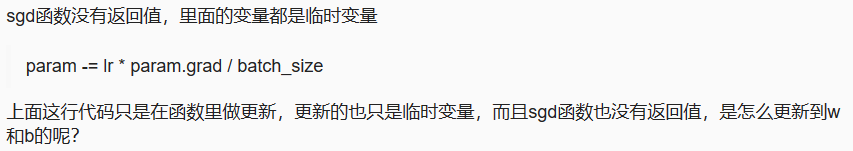
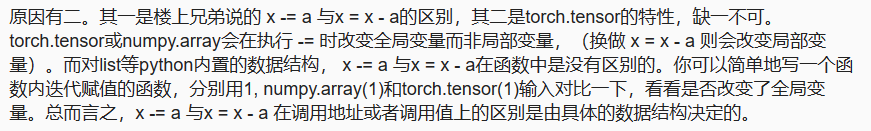

In [17]:
I = torch.normal(0,0.01,size=(1,),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size,features,labels):
        l = loss(net(x,I,b),y)
        l.sum().backward()
        # 更新参数 w，b
        sgd([I,b], lr, batch_size)
    # 计算每一轮的loss
    with torch.no_grad():
        train_l = loss(net(features,I,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):.5f}')

epoch 1, loss 0.00484
epoch 2, loss 0.00006
epoch 3, loss 0.00005


QA3
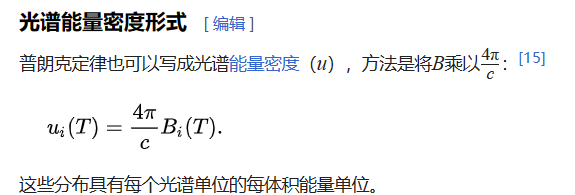
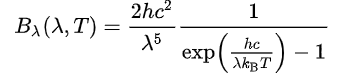

In [19]:
# QA4 f(x)=x^2 + sin(x) -> f'(x)=2 * x + cos(x) -> f''(x)=2 - sin(x)
"""
二阶导遇到的问题应该是一阶导函数计算式无法直接获取。解决方法：求一阶导数保存计算图
"""
import math
import torch
import numpy as np

x = torch.tensor([math.pi / 2, math.pi],requires_grad=True)
y = x**2 + torch.sin(x)

# 真实解
true_dy = 2 * x + torch.cos(x)
true_d2y = 2 - torch.sin(x)

# 自动求导
dy = torch.autograd.grad(y, x, 
                         grad_outputs=torch.ones(x.shape),
                        create_graph=True,
                        retain_graph=True) # 保存计算图
print(dy)
print(f'一阶导真实值:{true_dy.detach().numpy()}\n一阶导数计算值:{dy[0].detach().numpy()}')

d2y = torch.autograd.grad(dy[0],x,
                         grad_outputs=torch.ones(x.shape),
                         create_graph=False) # 不创建计算图并销毁前面的计算图

print(f'二阶导真实值:{true_d2y.detach().numpy()}\n二阶导数计算值:{d2y[0].detach().numpy()}')


(tensor([3.1416, 5.2832], grad_fn=<AddBackward0>),)
一阶导真实值:[3.1415927 5.2831855]
一阶导数计算值:[3.1415927 5.2831855]
二阶导真实值:[1. 2.]
二阶导数计算值:[1. 2.]


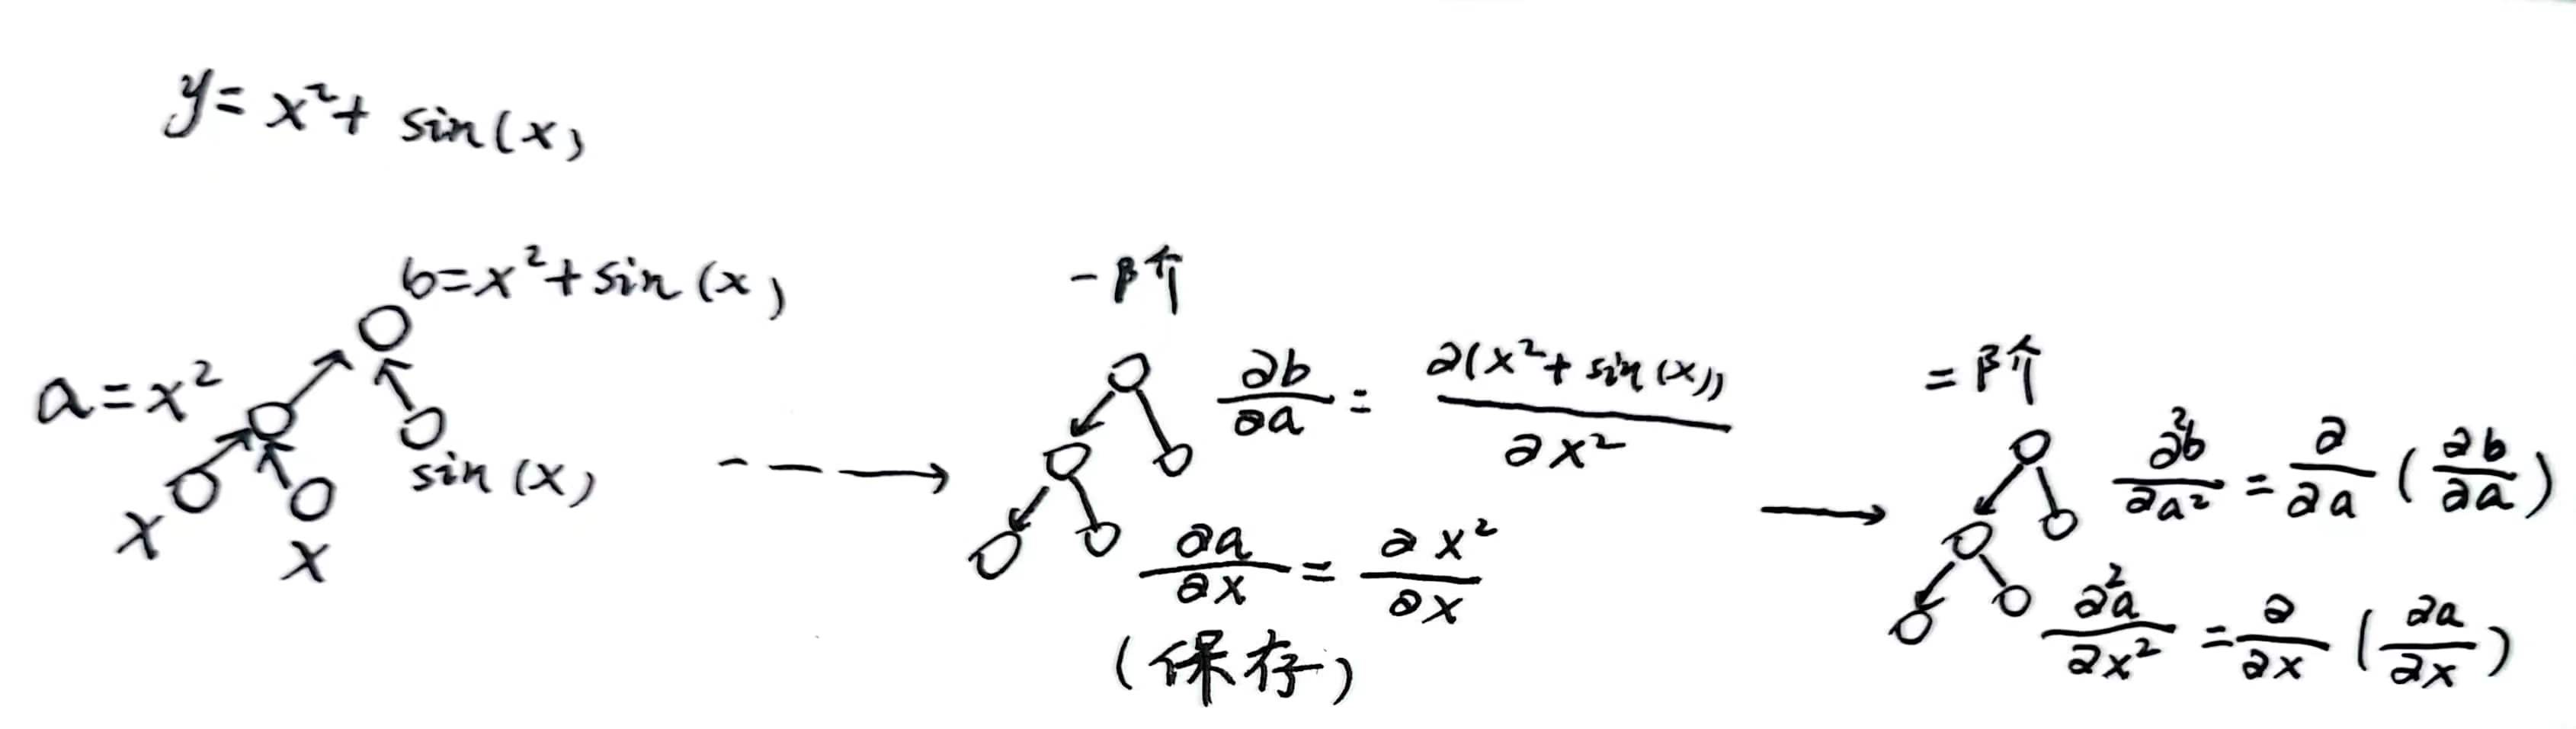

In [20]:
# QA5 测试
def synthetic_data(w,b,num_examples):
    x = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(x,w) + b
    # 增加噪声
    y += torch.normal(0,0.01,y.shape)
    return x, y.reshape((-1,1))

def squared_loss(y_hat,y):
    # 均方误差
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

w = torch.tensor([2,3.4],requires_grad=True)
b = torch.zeros(1,requires_grad=True)
features,labels = synthetic_data(w,b,1000)

y = torch.matmul(features,w) + b

squared_loss(y,labels).shape,y.shape,labels.shape

(torch.Size([1000]), torch.Size([1000]), torch.Size([1000, 1]))

In [21]:
def squared_loss_without_reshape(y_hat,y):
    # 均方误差
    return (y_hat - y)**2 / 2


"""
可以看出若无reshape函数，会引起广播机制，导致最终形状与预期的不一致
"""
squared_loss_without_reshape(y,labels).shape,(y - labels).shape

(torch.Size([1000, 1000]), torch.Size([1000, 1000]))

In [22]:
# QA6
true_w = torch.tensor([2,-3.4])
true_b = 4.3
features, labels = synthetic_data(true_w, true_b, 1000)

w = torch.zeros(2,1,requires_grad=True)
b = torch.zeros(1,requires_grad=True)

# lr取大了,在最优解附近震荡
lr = 0.5
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)
        l.sum().backward()
        # 更新参数 w，b
        sgd([w,b], lr, batch_size)
    # 计算每一轮的loss
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):.5f}')

epoch 1, loss 0.00005
epoch 2, loss 0.00005
epoch 3, loss 0.00005
epoch 4, loss 0.00005
epoch 5, loss 0.00005
epoch 6, loss 0.00005
epoch 7, loss 0.00005
epoch 8, loss 0.00006
epoch 9, loss 0.00005
epoch 10, loss 0.00005


In [23]:
true_w = torch.tensor([2,-3.4])
true_b = 4.3
features, labels = synthetic_data(true_w, true_b, 1000)

w = torch.zeros(2,1,requires_grad=True)
b = torch.zeros(1,requires_grad=True)

# lr取小了，梯度下降速度贼慢
lr = 0.001
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)
        l.sum().backward()
        # 更新参数 w，b
        sgd([w,b], lr, batch_size)
    # 计算每一轮的loss
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):.5f}')

epoch 1, loss 13.89973
epoch 2, loss 11.38488
epoch 3, loss 9.32529
epoch 4, loss 7.63851
epoch 5, loss 6.25700


In [24]:
# QA7 : 最后一次的批量数量小于batch_size